In [1]:
import os
print(os.listdir("../input"))

['brain-mri-images']


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
import time

print("Libraries successfully imported for brain MRI GAN.")

Libraries successfully imported for brain MRI GAN.


Found 14715 valid brain MRI images.


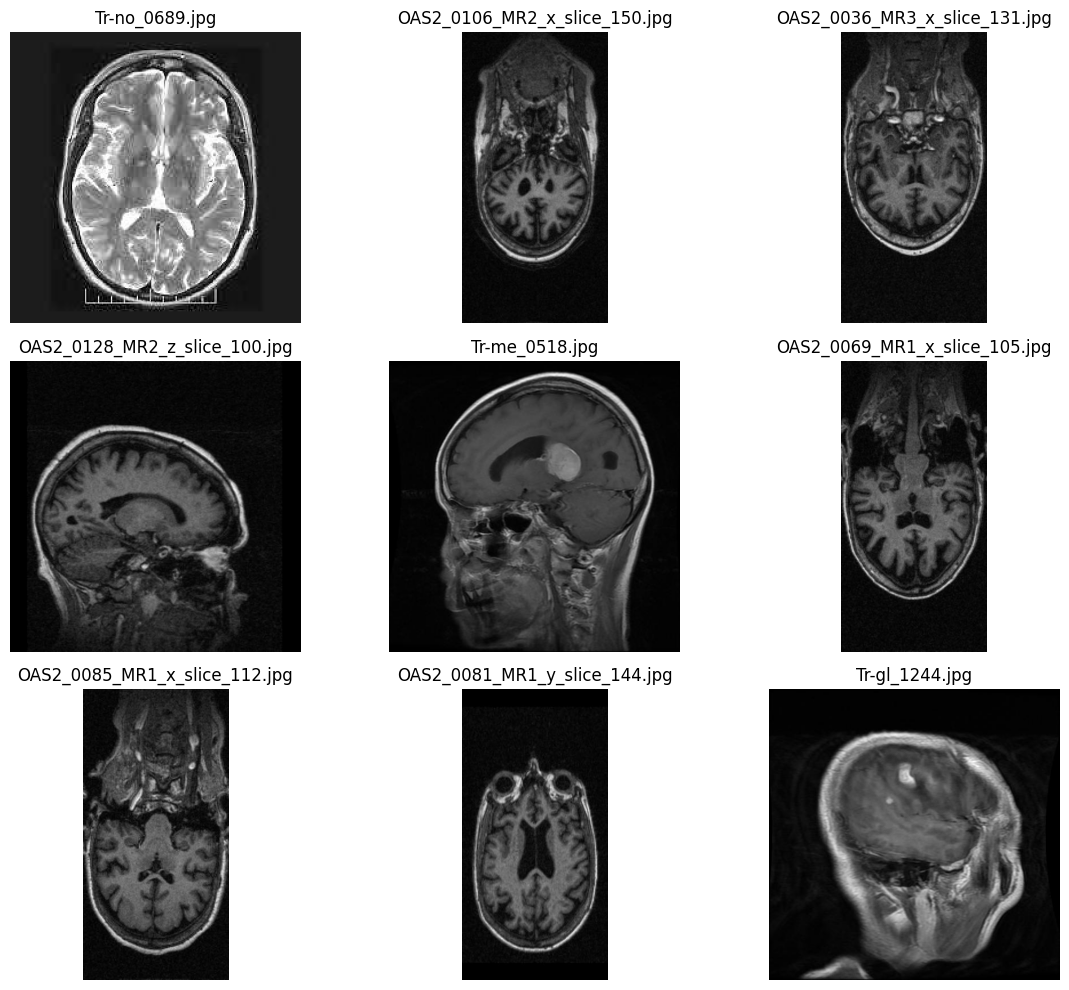

In [3]:
# Path to the brain MRI images dataset
PATH = '../input/brain-mri-images/GAN-Traning Images/'
assert os.path.exists(PATH), f"Path {PATH} does not exist!"

images = [f for f in os.listdir(PATH) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
print(f'Found {len(images)} valid brain MRI images.')

fig, axes = plt.subplots(3, 3, figsize=(12, 10))
for ax in axes.flatten():
    img_path = os.path.join(PATH, np.random.choice(images))
    img = plt.imread(img_path)
    ax.imshow(img, cmap='gray')
    ax.set_title(os.path.basename(img_path))
    ax.axis('off')
plt.tight_layout()

In [4]:
batch_size = 64
image_size = 64

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Fixed path to point to actual image directory
dataset = datasets.ImageFolder(root='../input/brain-mri-images/', transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Visualization
batch = next(iter(dataloader))
print(f"Batch shape: {batch[0].shape}")

Batch shape: torch.Size([64, 1, 64, 64])


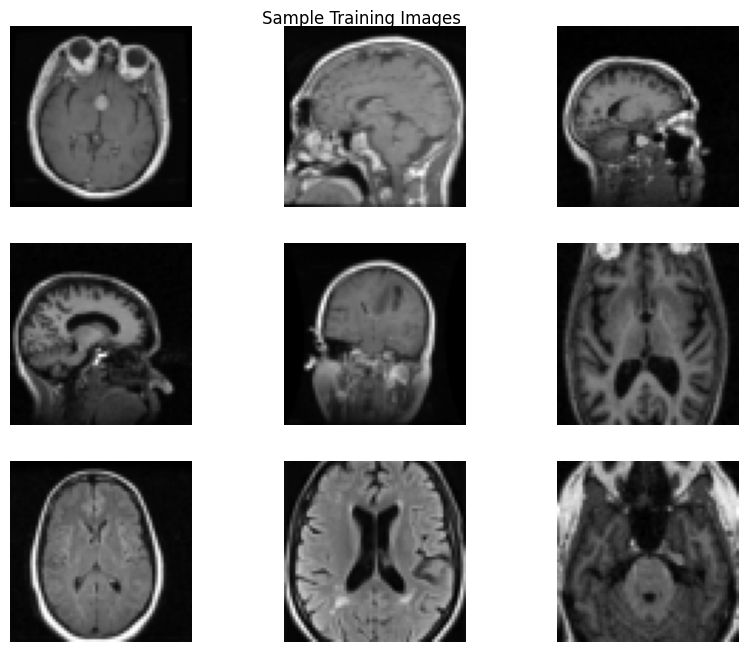

In [5]:
plt.figure(figsize=(10, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(batch[0][i].permute(1, 2, 0).numpy().squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle('Sample Training Images', y=0.9)
plt.show()

In [6]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()
        self.main = nn.Sequential(
            # Input: latent_dim x 1 x 1
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
           nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

netG = Generator().apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # Input: 1 x 64 x 64
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
             nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1)

netD = Discriminator().apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

netG = netG.to(device)
netD = netD.to(device)

# Fixed noise for visualization
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

Using device: cuda


In [10]:
import os

# Create the results folder if it doesn't exist
results_dir = "./results"
os.makedirs(results_dir, exist_ok=True)

In [11]:
# Only needed if running in Google Colab
if 'COLAB_GPU' in os.environ:
    !mkdir -p /content/results
    !ls /content

In [12]:
# Fix non-breaking spaces in all notebook cells
from IPython.core.interactiveshell import InteractiveShell

def clean_nb_spaces():
    shell = InteractiveShell.instance()
    for cell in shell.user_ns['_ih']:
        if '\u00A0' in cell:
            clean_cell = cell.replace('\u00A0', ' ')
            shell.set_next_input(clean_cell, replace=True)

clean_nb_spaces()
print("Fixed non-breaking spaces in the notebook!")

Fixed non-breaking spaces in the notebook!


In [13]:



# Hyperparameters
lr = 0.0001
epochs = 100

# Loss and optimizers
criterion = nn.BCELoss()
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))

# Label smoothing
real_label = 0.9

fake_label=0.1

In [14]:
import torchvision.utils as vutils

G_losses = []
D_losses = []
img_list = []

for epoch in range(epochs):
    for i, (real_imgs, _) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")):
        # Move data to device
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        netD.zero_grad()
        
        # Real images
        label = torch.full((batch_size,), real_label, device=device)
        output = netD(real_imgs)
        errD_real = criterion(output, label)
        errD_real.backward()
        
        # Fake images
        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        fake_imgs = netG(noise)
        label.fill_(fake_label)
        output = netD(fake_imgs.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        
        errD = errD_real + errD_fake
        optimizerD.step()
        
        # -----------------
        #  Train Generator
        # -----------------
        netG.zero_grad()
        label.fill_(real_label)  # Fake labels are real for generator
        output = netD(fake_imgs)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()
        
        # Save losses
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Save training progress
        if i % 100 == 0:
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
    
   # Save checkpoint
    if (epoch+1) % 10 == 0:
        torch.save({
            'epoch': epoch,
            'G_state_dict': netG.state_dict(),
            'D_state_dict': netD.state_dict(),
            'G_loss': G_losses,
            'D_loss': D_losses,
        }, f'./gan_checkpoint_epoch_{epoch+1}.pth')
    
    # Show progress
    print(f"[Epoch {epoch+1}/{epochs}] Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f}")

Epoch 1/100: 100%|██████████| 230/230 [00:25<00:00,  8.93it/s]


[Epoch 1/100] Loss_D: 0.7285 Loss_G: 1.8396


Epoch 2/100: 100%|██████████| 230/230 [00:24<00:00,  9.40it/s]


[Epoch 2/100] Loss_D: 0.6984 Loss_G: 2.2024


Epoch 3/100: 100%|██████████| 230/230 [00:25<00:00,  8.95it/s]


[Epoch 3/100] Loss_D: 0.7327 Loss_G: 2.7508


Epoch 4/100: 100%|██████████| 230/230 [00:27<00:00,  8.40it/s]


[Epoch 4/100] Loss_D: 0.7366 Loss_G: 2.4704


Epoch 5/100: 100%|██████████| 230/230 [00:28<00:00,  7.99it/s]


[Epoch 5/100] Loss_D: 0.7703 Loss_G: 1.9740


Epoch 6/100: 100%|██████████| 230/230 [00:27<00:00,  8.35it/s]


[Epoch 6/100] Loss_D: 0.6992 Loss_G: 2.4864


Epoch 7/100: 100%|██████████| 230/230 [00:27<00:00,  8.32it/s]


[Epoch 7/100] Loss_D: 1.1518 Loss_G: 1.2031


Epoch 8/100: 100%|██████████| 230/230 [00:28<00:00,  8.12it/s]


[Epoch 8/100] Loss_D: 0.7823 Loss_G: 1.9914


Epoch 9/100: 100%|██████████| 230/230 [00:27<00:00,  8.28it/s]


[Epoch 9/100] Loss_D: 0.7449 Loss_G: 2.0851


Epoch 10/100: 100%|██████████| 230/230 [00:27<00:00,  8.24it/s]


[Epoch 10/100] Loss_D: 0.7483 Loss_G: 1.8860


Epoch 11/100: 100%|██████████| 230/230 [00:28<00:00,  8.13it/s]


[Epoch 11/100] Loss_D: 0.7547 Loss_G: 2.2948


Epoch 12/100: 100%|██████████| 230/230 [00:28<00:00,  8.18it/s]


[Epoch 12/100] Loss_D: 0.7602 Loss_G: 2.0286


Epoch 13/100: 100%|██████████| 230/230 [00:27<00:00,  8.24it/s]


[Epoch 13/100] Loss_D: 0.7524 Loss_G: 1.5883


Epoch 14/100: 100%|██████████| 230/230 [00:27<00:00,  8.27it/s]


[Epoch 14/100] Loss_D: 0.7146 Loss_G: 1.8380


Epoch 15/100: 100%|██████████| 230/230 [00:27<00:00,  8.27it/s]


[Epoch 15/100] Loss_D: 0.7977 Loss_G: 1.5990


Epoch 16/100: 100%|██████████| 230/230 [00:27<00:00,  8.23it/s]


[Epoch 16/100] Loss_D: 0.8784 Loss_G: 0.9737


Epoch 17/100: 100%|██████████| 230/230 [00:28<00:00,  8.19it/s]


[Epoch 17/100] Loss_D: 0.7374 Loss_G: 1.9768


Epoch 18/100: 100%|██████████| 230/230 [00:28<00:00,  8.17it/s]


[Epoch 18/100] Loss_D: 0.7930 Loss_G: 1.8345


Epoch 19/100: 100%|██████████| 230/230 [00:28<00:00,  8.13it/s]


[Epoch 19/100] Loss_D: 0.9314 Loss_G: 3.2502


Epoch 20/100: 100%|██████████| 230/230 [00:28<00:00,  8.21it/s]


[Epoch 20/100] Loss_D: 0.7575 Loss_G: 2.0656


Epoch 21/100: 100%|██████████| 230/230 [00:27<00:00,  8.22it/s]


[Epoch 21/100] Loss_D: 0.7210 Loss_G: 1.8543


Epoch 22/100: 100%|██████████| 230/230 [00:27<00:00,  8.24it/s]


[Epoch 22/100] Loss_D: 0.7279 Loss_G: 1.7934


Epoch 23/100: 100%|██████████| 230/230 [00:27<00:00,  8.26it/s]


[Epoch 23/100] Loss_D: 0.7121 Loss_G: 2.5654


Epoch 24/100: 100%|██████████| 230/230 [00:27<00:00,  8.25it/s]


[Epoch 24/100] Loss_D: 0.7253 Loss_G: 2.1980


Epoch 25/100: 100%|██████████| 230/230 [00:27<00:00,  8.22it/s]


[Epoch 25/100] Loss_D: 0.8626 Loss_G: 1.1082


Epoch 26/100: 100%|██████████| 230/230 [00:28<00:00,  8.20it/s]


[Epoch 26/100] Loss_D: 0.7072 Loss_G: 2.4949


Epoch 27/100: 100%|██████████| 230/230 [00:28<00:00,  8.18it/s]


[Epoch 27/100] Loss_D: 0.7277 Loss_G: 2.6752


Epoch 28/100: 100%|██████████| 230/230 [00:28<00:00,  8.17it/s]


[Epoch 28/100] Loss_D: 0.7337 Loss_G: 1.8423


Epoch 29/100: 100%|██████████| 230/230 [00:28<00:00,  8.19it/s]


[Epoch 29/100] Loss_D: 0.7719 Loss_G: 1.4597


Epoch 30/100: 100%|██████████| 230/230 [00:28<00:00,  8.19it/s]


[Epoch 30/100] Loss_D: 0.7820 Loss_G: 3.0022


Epoch 31/100: 100%|██████████| 230/230 [00:28<00:00,  8.19it/s]


[Epoch 31/100] Loss_D: 0.8423 Loss_G: 0.9445


Epoch 32/100: 100%|██████████| 230/230 [00:28<00:00,  8.21it/s]


[Epoch 32/100] Loss_D: 0.7338 Loss_G: 1.8480


Epoch 33/100: 100%|██████████| 230/230 [00:27<00:00,  8.23it/s]


[Epoch 33/100] Loss_D: 0.7107 Loss_G: 2.2517


Epoch 34/100: 100%|██████████| 230/230 [00:28<00:00,  8.20it/s]


[Epoch 34/100] Loss_D: 0.8125 Loss_G: 2.7589


Epoch 35/100: 100%|██████████| 230/230 [00:28<00:00,  8.20it/s]


[Epoch 35/100] Loss_D: 0.7194 Loss_G: 1.9098


Epoch 36/100: 100%|██████████| 230/230 [00:28<00:00,  8.16it/s]


[Epoch 36/100] Loss_D: 0.7093 Loss_G: 2.4164


Epoch 37/100: 100%|██████████| 230/230 [00:28<00:00,  8.19it/s]


[Epoch 37/100] Loss_D: 0.7477 Loss_G: 2.0630


Epoch 38/100: 100%|██████████| 230/230 [00:28<00:00,  8.20it/s]


[Epoch 38/100] Loss_D: 0.7123 Loss_G: 2.0507


Epoch 39/100: 100%|██████████| 230/230 [00:27<00:00,  8.22it/s]


[Epoch 39/100] Loss_D: 0.7061 Loss_G: 2.4023


Epoch 40/100: 100%|██████████| 230/230 [00:28<00:00,  8.18it/s]


[Epoch 40/100] Loss_D: 0.7290 Loss_G: 1.9819


Epoch 41/100: 100%|██████████| 230/230 [00:28<00:00,  8.16it/s]


[Epoch 41/100] Loss_D: 0.6946 Loss_G: 2.4047


Epoch 42/100: 100%|██████████| 230/230 [00:28<00:00,  8.21it/s]


[Epoch 42/100] Loss_D: 0.7440 Loss_G: 1.6826


Epoch 43/100: 100%|██████████| 230/230 [00:27<00:00,  8.23it/s]


[Epoch 43/100] Loss_D: 0.7056 Loss_G: 1.7839


Epoch 44/100: 100%|██████████| 230/230 [00:27<00:00,  8.25it/s]


[Epoch 44/100] Loss_D: 0.7488 Loss_G: 1.9525


Epoch 45/100: 100%|██████████| 230/230 [00:27<00:00,  8.26it/s]


[Epoch 45/100] Loss_D: 0.7001 Loss_G: 1.9579


Epoch 46/100: 100%|██████████| 230/230 [00:27<00:00,  8.26it/s]


[Epoch 46/100] Loss_D: 0.7383 Loss_G: 1.7123


Epoch 47/100: 100%|██████████| 230/230 [00:27<00:00,  8.27it/s]


[Epoch 47/100] Loss_D: 0.7659 Loss_G: 1.3957


Epoch 48/100: 100%|██████████| 230/230 [00:27<00:00,  8.27it/s]


[Epoch 48/100] Loss_D: 0.7152 Loss_G: 2.6808


Epoch 49/100: 100%|██████████| 230/230 [00:27<00:00,  8.22it/s]


[Epoch 49/100] Loss_D: 0.7334 Loss_G: 2.4090


Epoch 50/100: 100%|██████████| 230/230 [00:28<00:00,  8.17it/s]


[Epoch 50/100] Loss_D: 0.7346 Loss_G: 1.5210


Epoch 51/100: 100%|██████████| 230/230 [00:28<00:00,  8.18it/s]


[Epoch 51/100] Loss_D: 0.7140 Loss_G: 1.9473


Epoch 52/100: 100%|██████████| 230/230 [00:27<00:00,  8.22it/s]


[Epoch 52/100] Loss_D: 0.7745 Loss_G: 2.1497


Epoch 53/100: 100%|██████████| 230/230 [00:27<00:00,  8.24it/s]


[Epoch 53/100] Loss_D: 0.6840 Loss_G: 2.0572


Epoch 54/100: 100%|██████████| 230/230 [00:27<00:00,  8.23it/s]


[Epoch 54/100] Loss_D: 0.7317 Loss_G: 1.7568


Epoch 55/100: 100%|██████████| 230/230 [00:27<00:00,  8.24it/s]


[Epoch 55/100] Loss_D: 0.7134 Loss_G: 2.3586


Epoch 56/100: 100%|██████████| 230/230 [00:28<00:00,  8.19it/s]


[Epoch 56/100] Loss_D: 0.6949 Loss_G: 2.3130


Epoch 57/100: 100%|██████████| 230/230 [00:28<00:00,  8.18it/s]


[Epoch 57/100] Loss_D: 0.7014 Loss_G: 2.2079


Epoch 58/100: 100%|██████████| 230/230 [00:28<00:00,  8.15it/s]


[Epoch 58/100] Loss_D: 0.7030 Loss_G: 2.2115


Epoch 59/100: 100%|██████████| 230/230 [00:28<00:00,  8.19it/s]


[Epoch 59/100] Loss_D: 0.7233 Loss_G: 2.3250


Epoch 60/100: 100%|██████████| 230/230 [00:28<00:00,  8.16it/s]


[Epoch 60/100] Loss_D: 0.6989 Loss_G: 2.0609


Epoch 61/100: 100%|██████████| 230/230 [00:28<00:00,  8.14it/s]


[Epoch 61/100] Loss_D: 0.7567 Loss_G: 2.2948


Epoch 62/100: 100%|██████████| 230/230 [00:28<00:00,  8.21it/s]


[Epoch 62/100] Loss_D: 0.7293 Loss_G: 1.7897


Epoch 63/100: 100%|██████████| 230/230 [00:28<00:00,  8.21it/s]


[Epoch 63/100] Loss_D: 0.6942 Loss_G: 2.2453


Epoch 64/100: 100%|██████████| 230/230 [00:28<00:00,  8.20it/s]


[Epoch 64/100] Loss_D: 0.6923 Loss_G: 2.1110


Epoch 65/100: 100%|██████████| 230/230 [00:28<00:00,  8.19it/s]


[Epoch 65/100] Loss_D: 0.7221 Loss_G: 2.1962


Epoch 66/100: 100%|██████████| 230/230 [00:28<00:00,  8.20it/s]


[Epoch 66/100] Loss_D: 0.7477 Loss_G: 1.5544


Epoch 67/100: 100%|██████████| 230/230 [00:28<00:00,  8.14it/s]


[Epoch 67/100] Loss_D: 0.7229 Loss_G: 1.5286


Epoch 68/100: 100%|██████████| 230/230 [00:28<00:00,  8.17it/s]


[Epoch 68/100] Loss_D: 0.7540 Loss_G: 1.8997


Epoch 69/100: 100%|██████████| 230/230 [00:28<00:00,  8.12it/s]


[Epoch 69/100] Loss_D: 0.7148 Loss_G: 2.3060


Epoch 70/100: 100%|██████████| 230/230 [00:28<00:00,  8.18it/s]


[Epoch 70/100] Loss_D: 0.7486 Loss_G: 1.8974


Epoch 71/100: 100%|██████████| 230/230 [00:27<00:00,  8.24it/s]


[Epoch 71/100] Loss_D: 0.7810 Loss_G: 3.2814


Epoch 72/100: 100%|██████████| 230/230 [00:27<00:00,  8.24it/s]


[Epoch 72/100] Loss_D: 0.7239 Loss_G: 2.3651


Epoch 73/100: 100%|██████████| 230/230 [00:27<00:00,  8.27it/s]


[Epoch 73/100] Loss_D: 0.7146 Loss_G: 2.0170


Epoch 74/100: 100%|██████████| 230/230 [00:27<00:00,  8.28it/s]


[Epoch 74/100] Loss_D: 0.7100 Loss_G: 1.8667


Epoch 75/100: 100%|██████████| 230/230 [00:27<00:00,  8.25it/s]


[Epoch 75/100] Loss_D: 0.7405 Loss_G: 1.5016


Epoch 76/100: 100%|██████████| 230/230 [00:27<00:00,  8.22it/s]


[Epoch 76/100] Loss_D: 0.6931 Loss_G: 2.1047


Epoch 77/100: 100%|██████████| 230/230 [00:28<00:00,  8.21it/s]


[Epoch 77/100] Loss_D: 0.7486 Loss_G: 1.7405


Epoch 78/100: 100%|██████████| 230/230 [00:28<00:00,  8.20it/s]


[Epoch 78/100] Loss_D: 0.7389 Loss_G: 2.8371


Epoch 79/100: 100%|██████████| 230/230 [00:28<00:00,  8.16it/s]


[Epoch 79/100] Loss_D: 0.7072 Loss_G: 1.9745


Epoch 80/100: 100%|██████████| 230/230 [00:28<00:00,  8.15it/s]


[Epoch 80/100] Loss_D: 0.6962 Loss_G: 2.3425


Epoch 81/100: 100%|██████████| 230/230 [00:28<00:00,  8.15it/s]


[Epoch 81/100] Loss_D: 0.7518 Loss_G: 1.5219


Epoch 82/100: 100%|██████████| 230/230 [00:28<00:00,  8.16it/s]


[Epoch 82/100] Loss_D: 0.6898 Loss_G: 2.0374


Epoch 83/100: 100%|██████████| 230/230 [00:28<00:00,  8.17it/s]


[Epoch 83/100] Loss_D: 0.7211 Loss_G: 1.5561


Epoch 84/100: 100%|██████████| 230/230 [00:28<00:00,  8.15it/s]


[Epoch 84/100] Loss_D: 0.6839 Loss_G: 2.6332


Epoch 85/100: 100%|██████████| 230/230 [00:28<00:00,  8.16it/s]


[Epoch 85/100] Loss_D: 0.6841 Loss_G: 2.2043


Epoch 86/100: 100%|██████████| 230/230 [00:28<00:00,  8.15it/s]


[Epoch 86/100] Loss_D: 0.6747 Loss_G: 2.3606


Epoch 87/100: 100%|██████████| 230/230 [00:28<00:00,  8.15it/s]


[Epoch 87/100] Loss_D: 0.7309 Loss_G: 2.7748


Epoch 88/100: 100%|██████████| 230/230 [00:28<00:00,  8.17it/s]


[Epoch 88/100] Loss_D: 0.6851 Loss_G: 2.6787


Epoch 89/100: 100%|██████████| 230/230 [00:28<00:00,  8.16it/s]


[Epoch 89/100] Loss_D: 0.6853 Loss_G: 2.1672


Epoch 90/100: 100%|██████████| 230/230 [00:28<00:00,  8.16it/s]


[Epoch 90/100] Loss_D: 0.6926 Loss_G: 1.8713


Epoch 91/100: 100%|██████████| 230/230 [00:28<00:00,  8.13it/s]


[Epoch 91/100] Loss_D: 0.6895 Loss_G: 1.8118


Epoch 92/100: 100%|██████████| 230/230 [00:28<00:00,  8.18it/s]


[Epoch 92/100] Loss_D: 0.6988 Loss_G: 1.6014


Epoch 93/100: 100%|██████████| 230/230 [00:27<00:00,  8.24it/s]


[Epoch 93/100] Loss_D: 0.6883 Loss_G: 1.9673


Epoch 94/100: 100%|██████████| 230/230 [00:27<00:00,  8.22it/s]


[Epoch 94/100] Loss_D: 0.7056 Loss_G: 2.4336


Epoch 95/100: 100%|██████████| 230/230 [00:27<00:00,  8.23it/s]


[Epoch 95/100] Loss_D: 0.6867 Loss_G: 2.4070


Epoch 96/100: 100%|██████████| 230/230 [00:28<00:00,  8.21it/s]


[Epoch 96/100] Loss_D: 0.6882 Loss_G: 2.1073


Epoch 97/100: 100%|██████████| 230/230 [00:28<00:00,  8.20it/s]


[Epoch 97/100] Loss_D: 0.6930 Loss_G: 2.5304


Epoch 98/100: 100%|██████████| 230/230 [00:28<00:00,  8.16it/s]


[Epoch 98/100] Loss_D: 0.7124 Loss_G: 1.4874


Epoch 99/100: 100%|██████████| 230/230 [00:28<00:00,  8.12it/s]


[Epoch 99/100] Loss_D: 0.6696 Loss_G: 2.3100


Epoch 100/100: 100%|██████████| 230/230 [00:28<00:00,  8.12it/s]

[Epoch 100/100] Loss_D: 0.7298 Loss_G: 2.6155


[14]


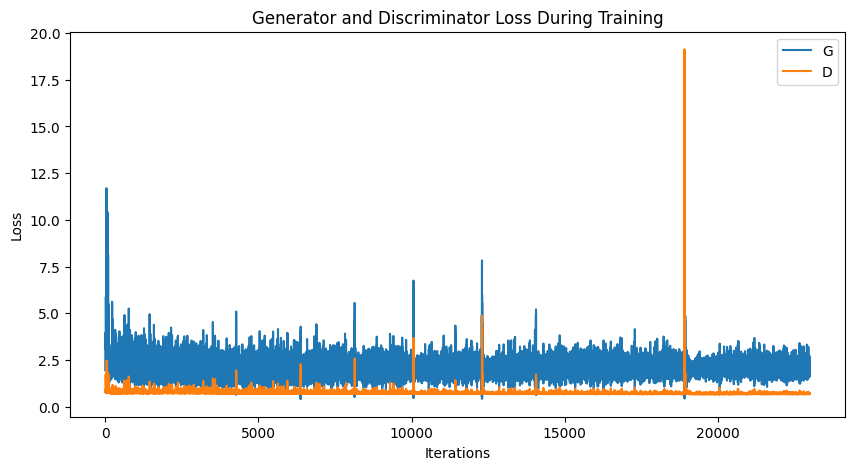

In [15]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

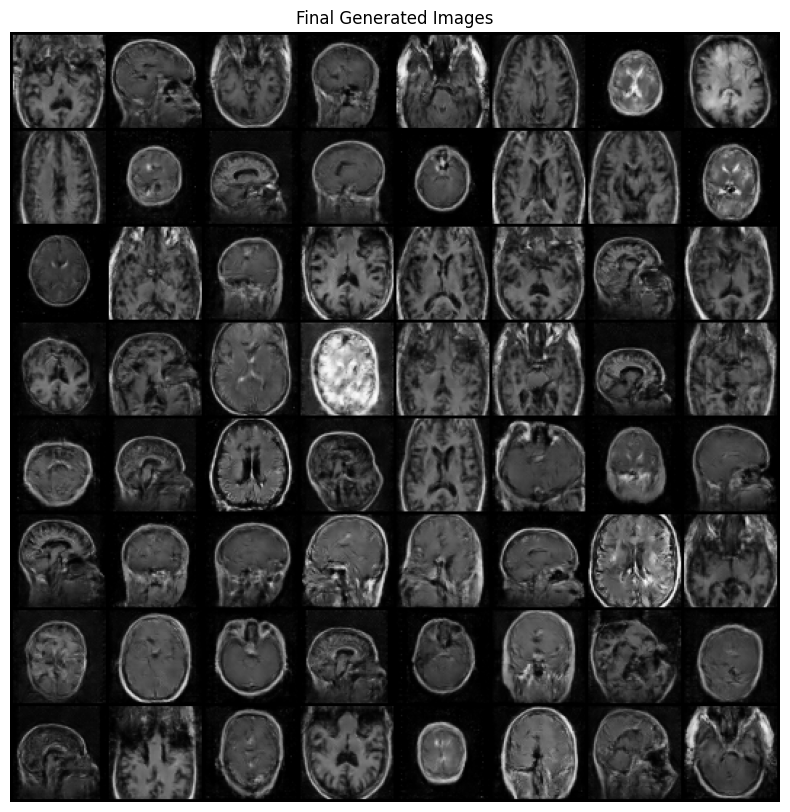

In [16]:
# Show final generated samples
fig = plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(np.transpose(img_list[-1], (1,2,0)))
plt.title("Final Generated Images")
plt.show()

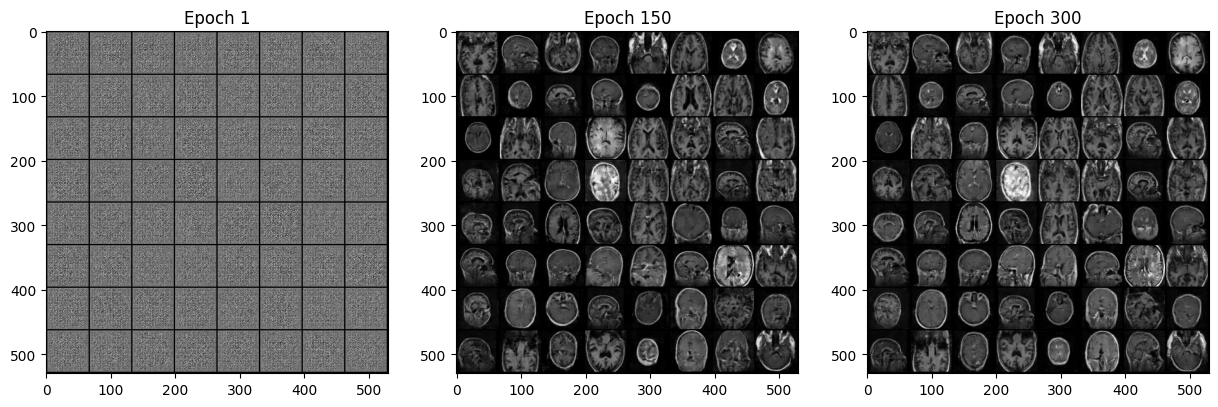

In [17]:
# Calculate actual epoch numbers for displayed images
total_epochs = 300  # Set this to your actual epoch count
samples_per_epoch = len(img_list) // total_epochs

# Show progression using actual epoch numbers
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# First sample (epoch 1)
ax[0].imshow(np.transpose(img_list[0], (1, 2, 0)))
ax[0].set_title('Epoch 1')

# Middle sample (actual middle epoch)
mid_epoch = total_epochs // 2
ax[1].imshow(np.transpose(img_list[mid_epoch * samples_per_epoch], (1, 2, 0)))
ax[1].set_title(f'Epoch {mid_epoch}')

# Final sample (last epoch)
ax[2].imshow(np.transpose(img_list[-1], (1, 2, 0)))
ax[2].set_title(f'Epoch {total_epochs}')

plt.show()

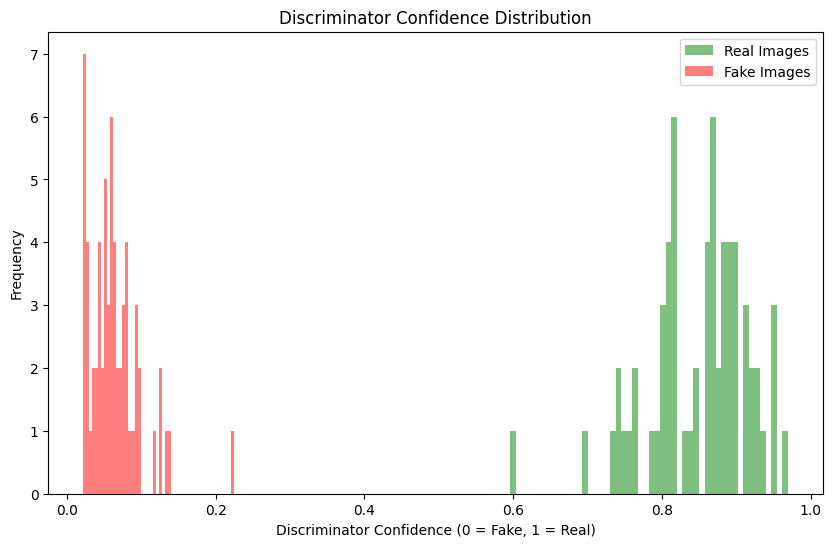

In [18]:
# Get real and fake images for analysis
real_batch = next(iter(dataloader))[0].to(device)
with torch.no_grad():
    # Get discriminator outputs
    d_real = netD(real_batch).cpu().numpy()
    fake = netG(torch.randn(real_batch.size(0), 100, 1, 1, device=device))
    d_fake = netD(fake).cpu().numpy()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(d_real, bins=50, alpha=0.5, label='Real Images', color='green')
plt.hist(d_fake, bins=50, alpha=0.5, label='Fake Images', color='red')
plt.xlabel('Discriminator Confidence (0 = Fake, 1 = Real)')
plt.ylabel('Frequency')
plt.title('Discriminator Confidence Distribution')
plt.legend()
plt.show()

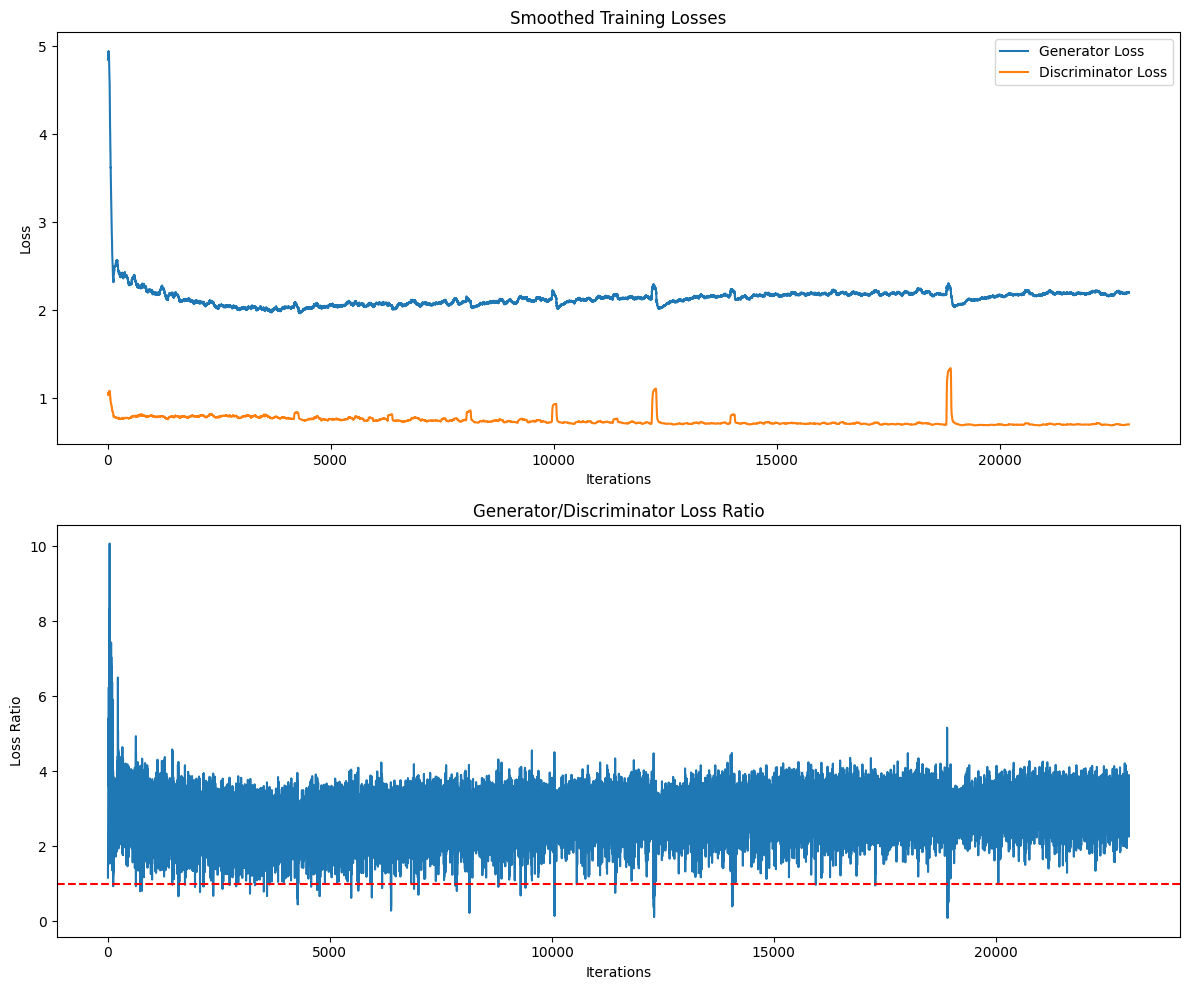

In [19]:
# Calculate metrics from loss arrays
window_size = 100
smoothed_G = np.convolve(G_losses, np.ones(window_size)/window_size, mode='valid')
smoothed_D = np.convolve(D_losses, np.ones(window_size)/window_size, mode='valid')

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Loss plot
ax1.plot(smoothed_G, label='Generator Loss')
ax1.plot(smoothed_D, label='Discriminator Loss')
ax1.set_title('Smoothed Training Losses')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss')
ax1.legend()

# Ratio plot
ax2.plot(np.array(G_losses)/np.array(D_losses))
ax2.set_title('Generator/Discriminator Loss Ratio')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Loss Ratio')
ax2.axhline(1, color='red', linestyle='--')

plt.tight_layout()
plt.show()

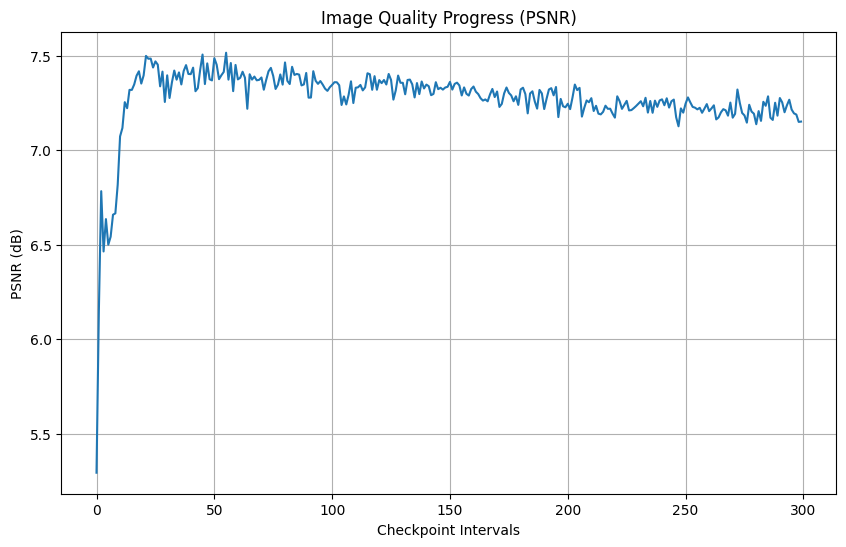

In [20]:
from skimage.metrics import peak_signal_noise_ratio as psnr

# Get a fixed batch of real images for consistent comparison
fixed_real = next(iter(dataloader))[0][:64].cpu().numpy()

psnr_scores = []
pad = 2  # Same as used in make_grid
image_size = 64  # Image dimensions (64x64)
nrow = 8         # Number of images per row in grid

for i, generated_grid in enumerate(img_list):
    # Convert grid tensor to numpy array (H, W, C)
    generated_grid = generated_grid.permute(1, 2, 0).numpy()
    batch_psnr = []
    
    # Compare first 8 images in grid with corresponding real images
    for j in range(8):
        # Calculate position in grid for j-th image (first row)
        row = 0
        col = j
        
        # Extract image slice from grid
        x_start = col * (image_size + pad)
        x_end = x_start + image_size
        y_start = row * (image_size + pad)
        y_end = y_start + image_size
        
        gen_slice = generated_grid[y_start:y_end, x_start:x_end, 0]  # Channel 0
        
        # Convert to 8-bit format (0-255)
        gen = (gen_slice * 127.5 + 127.5).astype(np.uint8)
        real = (fixed_real[j].squeeze() * 127.5 + 127.5).astype(np.uint8)
        
        # Calculate PSNR
        batch_psnr.append(psnr(real, gen, data_range=255))
    
    psnr_scores.append(np.mean(batch_psnr))

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(psnr_scores)
plt.title('Image Quality Progress (PSNR)')
plt.xlabel('Checkpoint Intervals')
plt.ylabel('PSNR (dB)')
plt.grid(True)
plt.show()

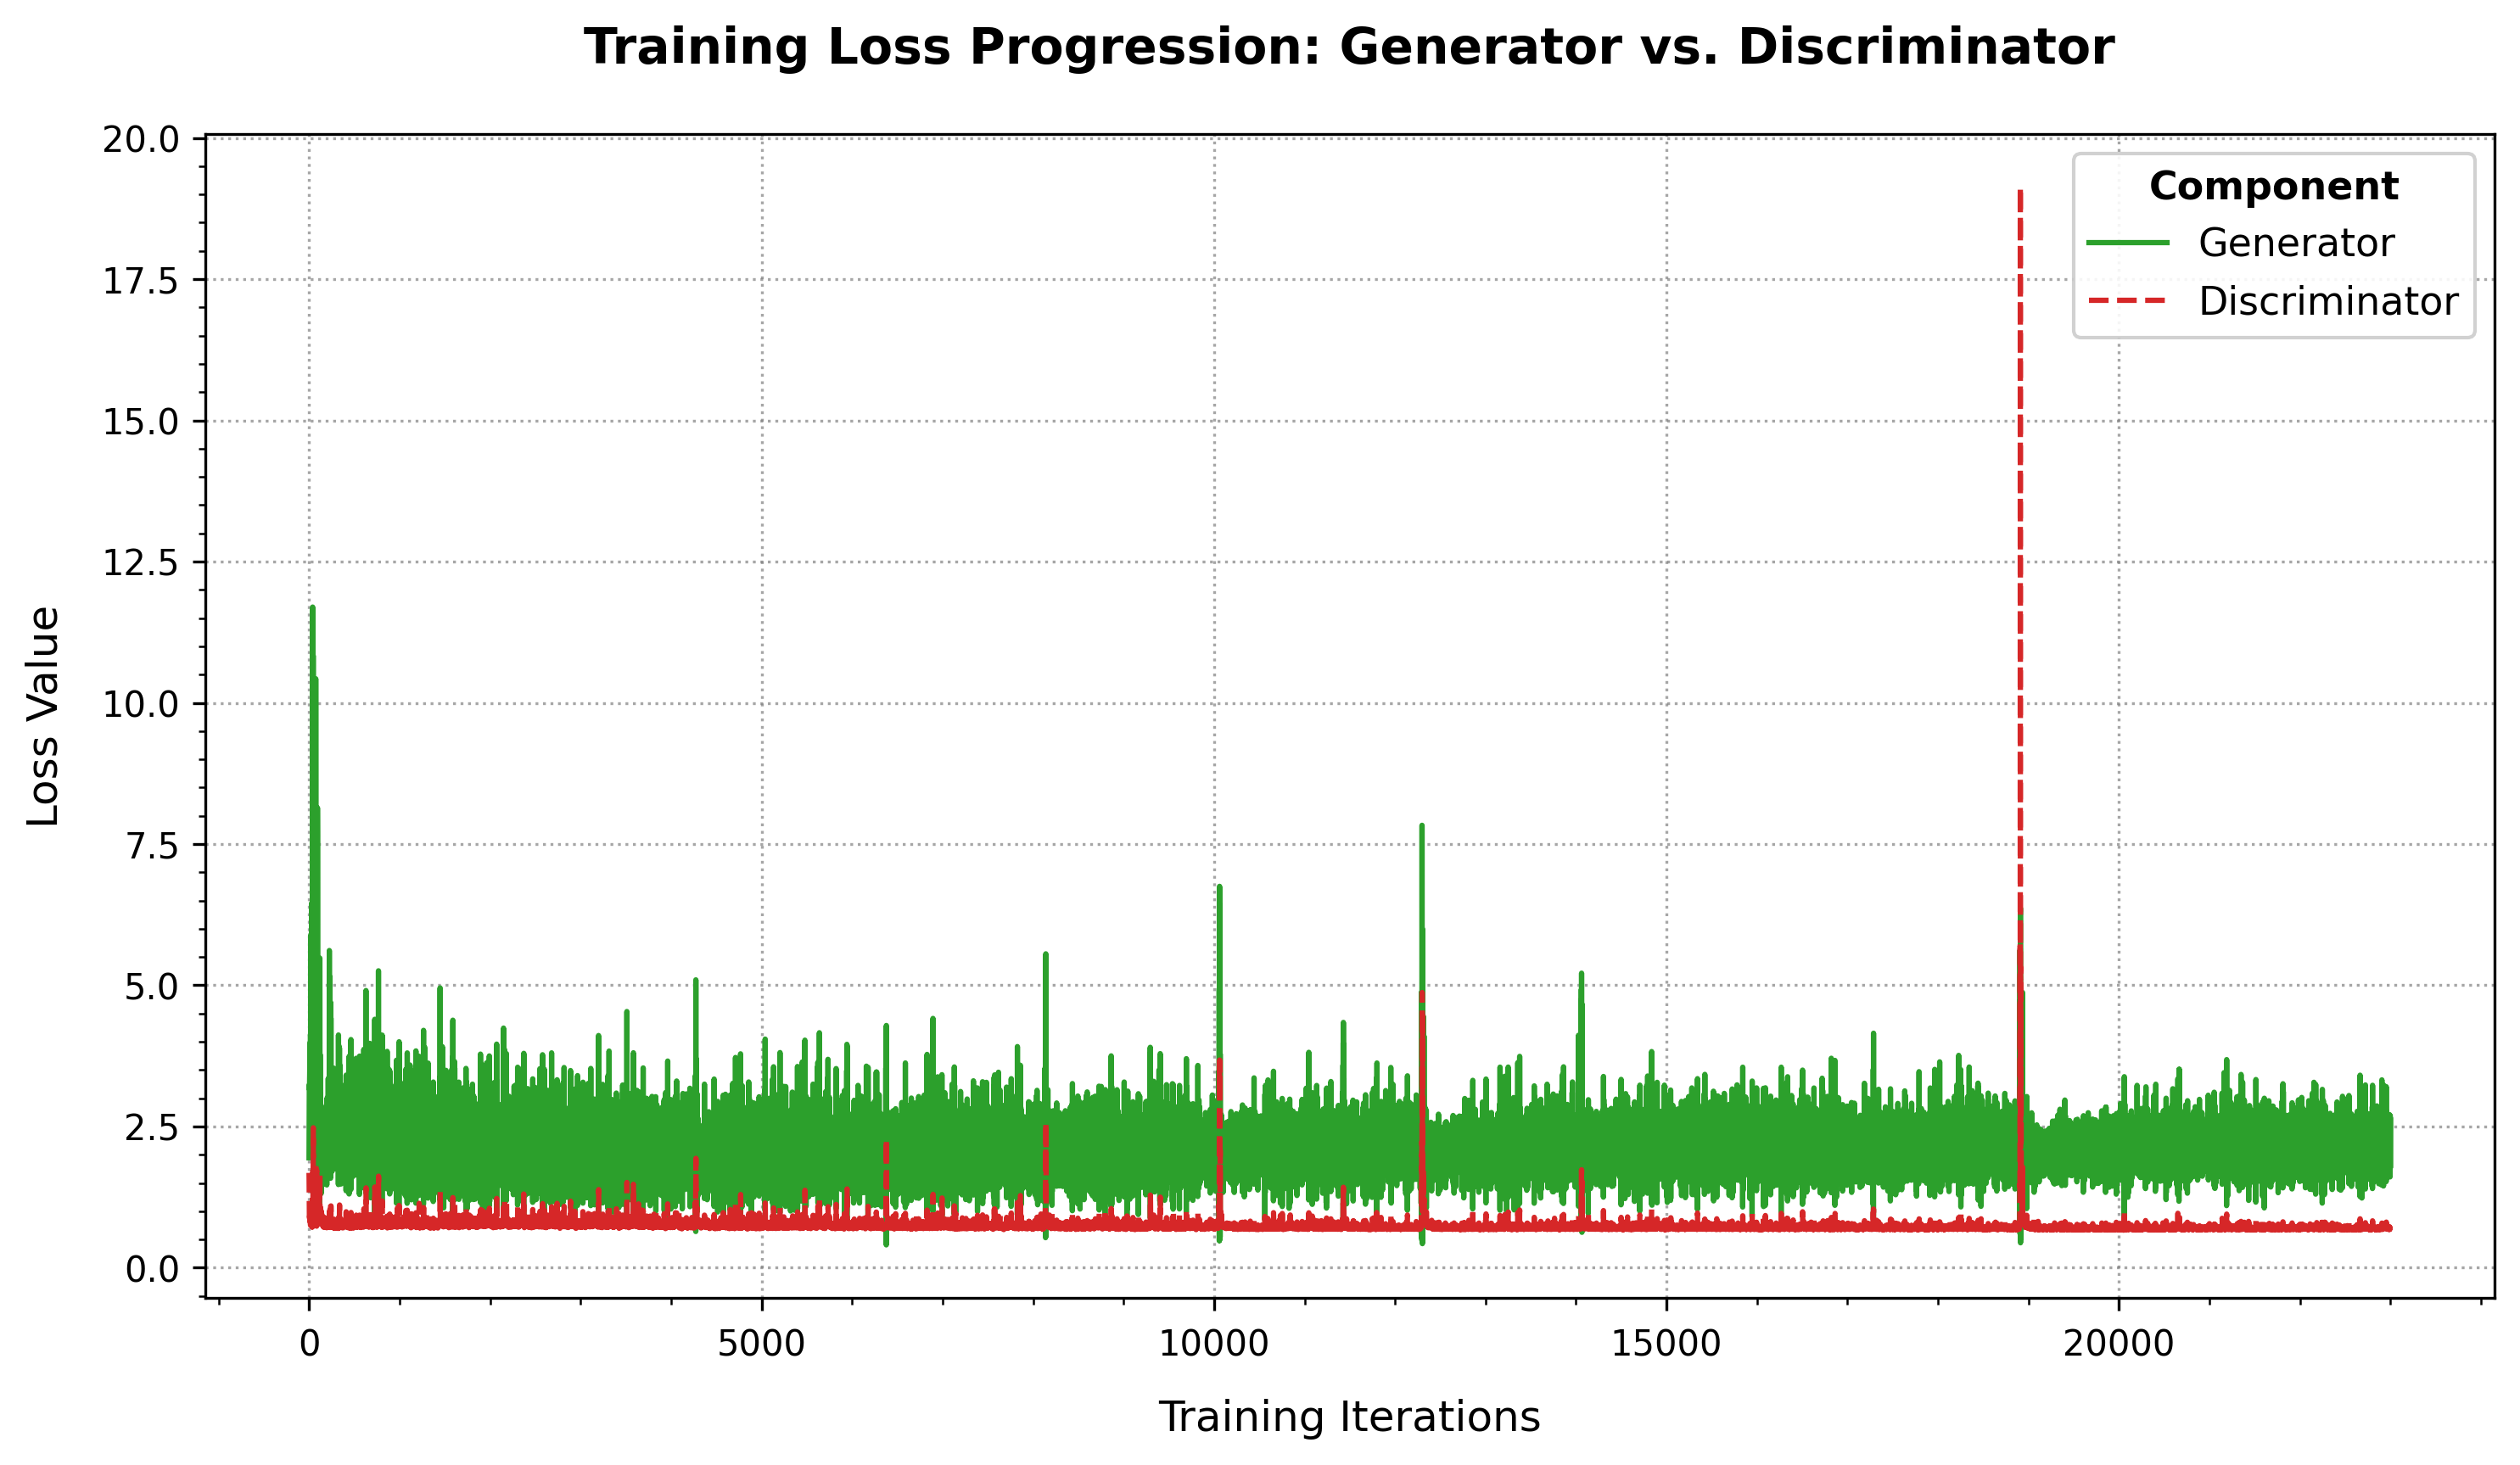

In [21]:
plt.figure(figsize=(10, 6), dpi=300)  # Higher resolution for publications
plt.title("Training Loss Progression: Generator vs. Discriminator", 
          fontsize=14, fontweight='semibold', pad=20)

# Plot with smoothed lines and proper styling
plt.plot(G_losses, label="Generator", color='#2ca02c', linewidth=1.5, linestyle='-')
plt.plot(D_losses, label="Discriminator", color='#d62728', linewidth=1.5, linestyle='--')

# Axis labels with proper capitalization
plt.xlabel("Training Iterations", fontsize=12, labelpad=10)
plt.ylabel("Loss Value", fontsize=12, labelpad=10)

# Grid and tick parameters
plt.grid(True, linestyle=':', color='gray', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='x', which='both', pad=5)

# Legend styling
legend = plt.legend(fontsize=11, loc='upper right', 
                    frameon=True, shadow=False, 
                    facecolor='white', framealpha=0.9)
legend.set_title("Component", prop={'size': 11, 'weight': 'semibold'})

# Add minor ticks and set limits if needed
plt.minorticks_on()
plt.gca().set_axisbelow(True)  # Grid behind data

# Adjust margins and layout
plt.tight_layout()
plt.subplots_adjust(top=0.88)  # Space for title

# Save as vector graphic for publications
plt.savefig('training_losses.pdf', format='pdf', bbox_inches='tight')
plt.show()

<ipython-input-22-0ec2de5f0032>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')  # Clean style


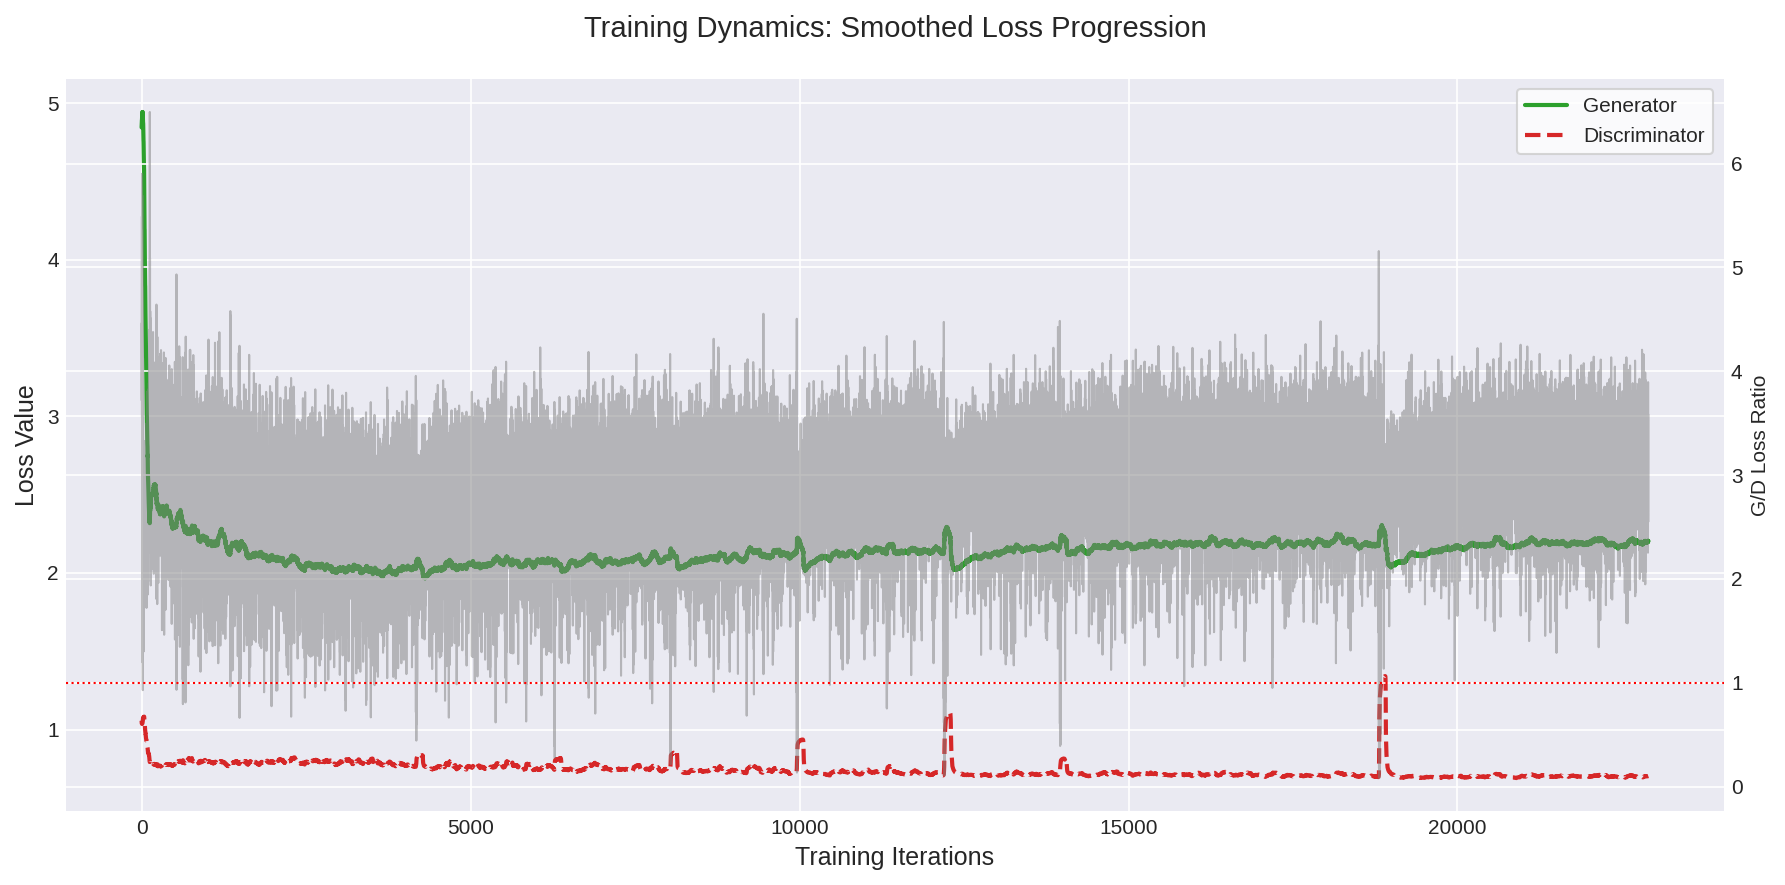

In [22]:
# Enhanced loss visualization with publication quality
plt.figure(figsize=(12, 6), dpi=150)
plt.style.use('seaborn-darkgrid')  # Clean style

# Smooth losses using convolution
window_size = 100
smoothed_G = np.convolve(G_losses, np.ones(window_size)/window_size, mode='valid')
smoothed_D = np.convolve(D_losses, np.ones(window_size)/window_size, mode='valid')

#  Plot with annotations
plt.plot(smoothed_G, linewidth=2, label='Generator', color='#2ca02c')
plt.plot(smoothed_D, linewidth=2, label='Discriminator', color='#d62728', linestyle='--')

plt.title('Training Dynamics: Smoothed Loss Progression', fontsize=14, pad=20)
plt.xlabel('Training Iterations', fontsize=12)
plt.ylabel('Loss Value', fontsize=12)
plt.legend(frameon=True, facecolor='white', loc='upper right')

# Add secondary axis for ratio
ax2 = plt.gca().twinx()
ratio_line = (np.array(G_losses)/np.array(D_losses))[window_size-1:]
ax2.plot(ratio_line, color='#7f7f7f', alpha=0.5, linewidth=1)
ax2.set_ylabel('G/D Loss Ratio', fontsize=10)
ax2.axhline(1, color='red', linestyle=':', linewidth=1)

plt.tight_layout()
plt.savefig('professional_training_metrics.pdf', bbox_inches='tight') 
plt.show()

In [23]:
import datetime

# Save final model with metadata
checkpoint = {
    'epoch': epochs,
    'timestamp': datetime.datetime.now().isoformat(),
    'G_state_dict': netG.state_dict(),
    'D_state_dict': netD.state_dict(),
    'G_optimizer': optimizerG.state_dict(),
    'D_optimizer': optimizerD.state_dict(),
    'losses': {'G': G_losses, 'D': D_losses},
    'hyperparameters': {
        'lr': lr,
        'batch_size': batch_size,
        'latent_dim': 100,
        'image_size': image_size
    }
}

torch.save(checkpoint, 'professional_brain_mri_gan.pth')

# Export to ONNX for production
dummy_input = torch.randn(1, 100, 1, 1, device=device)
torch.onnx.export(netG, dummy_input, "brain_mri_generator.onnx",
                 input_names=['noise'], output_names=['image'],
                  dynamic_axes={'noise': {0: 'batch_size'}, 'image': {0: 'batch_size'}})

In [24]:
# Generate textual training report
report = f"""BRAIN MRI GAN TRAINING REPORT
----------------------------------
Timestamp: {datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
Training Duration: ~{(len(G_losses)//len(dataloader)) * (time.perf_counter()//60)} minutes
Final Losses:
- Generator: {G_losses[-1]:.4f}
- Discriminator: {D_losses[-1]:.4f}

Hardware:
- Device: {device}
- CUDA Version: {torch.version.cuda}
- CUDNN Enabled: {torch.backends.cudnn.enabled}

Dataset:
- Samples: {len(dataset)}
- Augmentations: Grayscale, CenterCrop(64), Normalize
"""

with open('training_report.txt', 'w') as f:
    f.write(report)